# Mining Big Datasets - FT
### Assignment I

### Student Names:
## Eleni Ralli - f2822312 ,
## Viktor Kalatzis- f2822318  
## May, 2024


In [1]:
import networkx as nx
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
from joblib import Parallel, delayed
import time


file_path = r'C:\Users\eleni\Downloads\facebook_combined.txt'

print("File exists:", os.path.exists(file_path))


File exists: True


-  Load the Facebook ego-network dataset, which is initially directed and convert it to an undirected graph by adding reciprocal edges where necessary    
- load_graph function: Reads the dataset from a specified path, splitting each line to get node pairs and adding edges between them. By adding both (node1, node2) and (node2, node1),  it ensures that the graph is undirected, complying with the assignment's requirements to handle an undirected graph.

In [2]:
# Function to load the Facebook graph and convert to an undirected graph
def load_graph(file_path):
    G = nx.Graph()
    with open(file_path, 'r') as f:
        for line in f:
            node1, node2 = map(int, line.split())
            G.add_edge(node1, node2)
            G.add_edge(node2, node1)  # Add missing reciprocal edges
    return G

# Load the graph using the correct file path
graph = load_graph(file_path)

- Implement algorithms to recommend friends based on different graph-based metrics like common neighbors, 
Jaccard coefficients, and preferential attachment. Each function computes a list of recommended nodes based on the respective metric. These functions leverage 
NetworkX built-in functions to calculate scores based on network structure, then return the top recommendations.

In [3]:
# Recommendation Algorithms


# Common Neighbors
# This function recommends friends based on the number of mutual friends (common neighbors). 
# The more mutual friends two users have, the higher their recommendation score.
def recommend_common_neighbors(G, node, top_n=5):
    neighbors = set(G.neighbors(node))
    scores = {}
    for neighbor in neighbors:
        for second_degree in G.neighbors(neighbor):
            if second_degree != node and second_degree not in neighbors:
                scores[second_degree] = scores.get(second_degree, 0) + 1
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]


# Jaccard Coefficient
# This function recommends friends based on the Jaccard coefficient,
#which measures similarity between two sets by dividing the size of their intersection by the size of their union.
# It is useful for determining the likelihood of forming a link based on shared connections.
def recommend_jaccard(G, node, top_n=5):
    scores = nx.jaccard_coefficient(G, [(node, other) for other in G.nodes() if other != node and not G.has_edge(node, other)])
    return sorted(scores, key=lambda x: x[2], reverse=True)[:top_n]


# Preferential Attachment
# This function recommends friends based on the principle of preferential attachment, 
#where nodes with higher degrees (more connections) are more likely to form new links.
# The score is based on the product of the degrees of the two nodes.
def recommend_preferential_attachment(G, node, top_n=5):
    scores = nx.preferential_attachment(G, [(node, other) for other in G.nodes() if other != node and not G.has_edge(node, other)])
    return sorted(scores, key=lambda x: x[2], reverse=True)[:top_n]

- Batch Processing for Recommendations
- Objective: Utilize parallel processing to compute recommendations for potentially large subsets of the network efficiently.

- Batch Recommendations
 This function `recommend_all` is designed to compute friend recommendations for all nodes in the graph using the specified method.
 It takes in a graph `G`, a method for recommendation (which can be 'common_neighbors', 'jaccard', or 'preferential_attachment'), and the number of top recommendations to return `top_n`.
 The function uses a dictionary `recommend_fn` to map the method names to their corresponding recommendation functions.
 It then iterates over each node in the graph, applying the chosen recommendation function to compute the top_n recommendations for that node.
 The results are stored in a dictionary `recommendations` where each key is a node and the value is the list of recommended friends.
 This approach leverages Python's dictionary comprehension for efficient and concise batch processing of recommendations across the entire network.


In [4]:
#Batch Processing for Recommendations
#Objective: Utilize parallel processing 
#to compute recommendations for potentially large subsets of the network efficiently.

# Batch Recommendations
def recommend_all(G, method='common_neighbors', top_n=5):
    recommend_fn = {
        'common_neighbors': recommend_common_neighbors,
        'jaccard': recommend_jaccard,
        'preferential_attachment': recommend_preferential_attachment
    }[method]
    recommendations = {node: recommend_fn(G, node, top_n) for node in G.nodes()}
    return recommendations

- Parallel Recommendations Function
 This function `recommend_all_parallel` is designed to efficiently compute friend recommendations for all nodes in a graph using parallel processing. 
 It leverages the joblib library to parallelize the computation, which can significantly speed up the process when dealing with large graphs.

- The function takes the following parameters:
 - G: The input graph.
 - method: The recommendation method to use ('common_neighbors', 'jaccard', or 'preferential_attachment').
 - top_n: The number of top recommendations to return for each node.
 - node_limit: An optional limit on the number of nodes to process. This can be useful for testing or if only a subset of nodes is of interest.
 - n_jobs: The number of parallel jobs to run. By default, it is set to -1, which means using all available processors.

The function first selects the appropriate recommendation function based on the provided method. 
It then creates a list of nodes to process, either limiting it to node_limit or using all nodes in the graph if no limit is specified.
The inner function `recommend_fn_wrapper` is defined to wrap the recommendation function, pairing each node with its recommendations.

The joblib's Parallel and delayed functions are used to execute the recommendation function in parallel across the selected nodes.
The results are collected and returned as a dictionary, where each key is a node and the value is the list of recommended friends.


In [5]:
# Parallel Recommendations Function
def recommend_all_parallel(G, method='jaccard', top_n=5, node_limit=None, n_jobs=-1):
    recommend_fn = {
        'common_neighbors': recommend_common_neighbors,
        'jaccard': recommend_jaccard,
        'preferential_attachment': recommend_preferential_attachment
    }[method]

    if node_limit:
        nodes = list(G.nodes())[:node_limit]
    else:
        nodes = list(G.nodes())

    def recommend_fn_wrapper(node):
        return node, recommend_fn(G, node, top_n)

    results = Parallel(n_jobs=n_jobs)(delayed(recommend_fn_wrapper)(node) for node in nodes)
    return dict(results)

# Example Recommendations for node 0 using the Facebook dataset
print("Recommendations (Common Neighbors) for node 0:", recommend_common_neighbors(graph, 0))
print("Recommendations (Jaccard) for node 0:", recommend_jaccard(graph, 0))
print("Recommendations (Preferential Attachment) for node 0:", recommend_preferential_attachment(graph, 0))

# Time the execution
start = time.time()
all_recommendations = recommend_all_parallel(graph, method='jaccard', top_n=5, node_limit=1000, n_jobs=-1)
end = time.time()

print(f"Execution Time: {end - start:.2f} seconds")

# Save recommendations to file
with open('all_recommendations.json', 'w') as f:
    json.dump(all_recommendations, f, indent=2)

Recommendations (Common Neighbors) for node 0: [(348, 4), (414, 3), (1684, 3), (428, 2), (1912, 2)]
Recommendations (Jaccard) for node 0: [(0, 348, 0.006993006993006993), (0, 414, 0.005964214711729622), (0, 904, 0.005747126436781609), (0, 2838, 0.0057306590257879654), (0, 2885, 0.0057306590257879654)]
Recommendations (Preferential Attachment) for node 0: [(0, 1684, 274824), (0, 1912, 261985), (0, 3437, 189809), (0, 2543, 102018), (0, 2347, 100977)]
Execution Time: 163.31 seconds


- Subgraph Creation and Visualization: This code snippet focuses on creating a smaller, more manageable subgraph from the original Facebook graph dataset by selecting the first 50 edges. This subgraph allows for easier visualization and analysis.

- Graph Visualization: The subgraph is visualized using the spring_layout function from NetworkX, which employs a force-directed algorithm to position the nodes. The nodes are colored in light blue (#A0CBE2), and the edges are colored in green (#00bb5e). This visualization helps in understanding the structure and connectivity within this subset of the network. The graph is then saved as a PDF file named "graph_sample.pdf" for reference.

- Graph Information: The code provides a summary of the subgraph using the __str__ method, which prints a textual representation of the graph. Key metrics such as the number of nodes, number of edges, and average degree are computed and printed. These metrics provide a concise overview of the subgraph's properties, offering insights into its structure and connectivity. The average degree, calculated as the sum of degrees of all nodes divided by the number of nodes, indicates the average number of connections per node in the subgraph.

Graph with 51 nodes and 50 edges
Graph Information
Number of Nodes: 51
Number of Edges: 50
Average Degree: 1.96


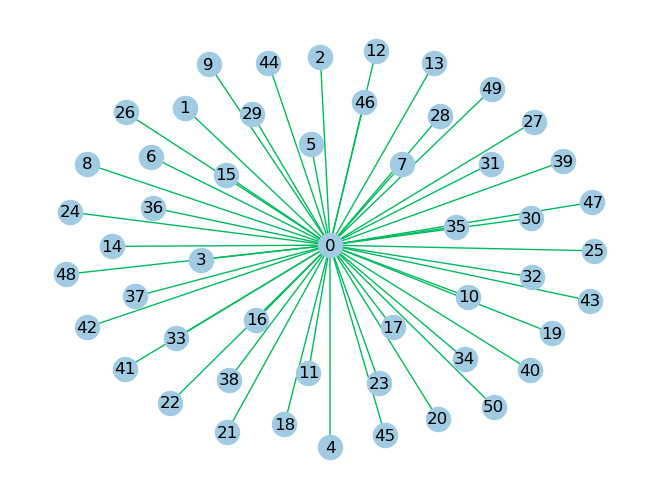

In [6]:
# Create a sample graph for visualization
sample_edges = list(graph.edges())[:50]
subgraph = nx.Graph()
subgraph.add_edges_from(sample_edges)

# Visualizing the sample graph
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color='#A0CBE2', edge_color='#00bb5e', width=1, edge_cmap=plt.cm.Blues, with_labels=True)
plt.savefig("graph_sample.pdf")

# Print subgraph information using the summary method
print(subgraph.__str__())

num_nodes = subgraph.number_of_nodes()
num_edges = subgraph.number_of_edges()
avg_degree = sum(dict(subgraph.degree()).values()) / num_nodes

print(f"Graph Information\nNumber of Nodes: {num_nodes}\nNumber of Edges: {num_edges}\nAverage Degree: {avg_degree:.2f}")


- Manual Test Graph Creation: This section of the code is dedicated to manually creating a smaller graph with predefined edges. The purpose is to provide a controlled environment for testing the recommendation algorithms, ensuring they produce the expected results.

- Graph Visualization: The small graph is visualized using the spring_layout function from NetworkX. The nodes are colored light blue (#A0CBE2), and the edges are colored green (#00bb5e). This visualization helps in understanding the structure and connectivity of the manually created graph. The graph is saved as a PDF file named "small_graph.pdf" for easy reference.

- Testing Recommendation Algorithms: The recommendation functions (recommend_common_neighbors, recommend_jaccard, recommend_preferential_attachment) are applied to node 0 in the small graph. The outputs are printed to manually verify the correctness of the algorithms in a simple, controlled setting. This manual testing is crucial for ensuring that the algorithms work as expected before applying them to larger and more complex datasets.

Recommendations (Common Neighbors) for node 0 (Small Graph): [(3, 1), (4, 1), (5, 1), (6, 1)]
Recommendations (Jaccard) for node 0 (Small Graph): [(0, 3, 0.3333333333333333), (0, 4, 0.3333333333333333), (0, 5, 0.3333333333333333), (0, 6, 0.25), (0, 7, 0.0)]
Recommendations (Preferential Attachment) for node 0 (Small Graph): [(0, 6, 6), (0, 7, 6), (0, 3, 4), (0, 4, 4), (0, 5, 4)]


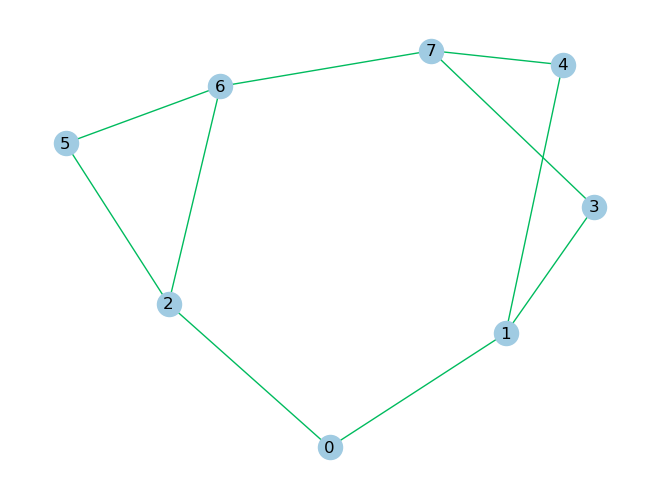

In [7]:
#Manual Test Graph Creation
#Objective: Create a smaller, simpler graph manually to test the algorithms and ensure they work as expected.
#Manual Testing: This section creates a graph with predefined edges, which is useful for testing the 
#recommendation functions in a controlled environment to ensure they produce the expected results.

small_graph = nx.Graph()
small_graph_edges = [
    (0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (4, 7), (5, 6), (6, 7)
]
small_graph.add_edges_from(small_graph_edges)

# Visualize the small graph
pos_small = nx.spring_layout(small_graph)
nx.draw(small_graph, pos_small, node_color='#A0CBE2', edge_color='#00bb5e', width=1, edge_cmap=plt.cm.Blues, with_labels=True)
plt.savefig("small_graph.pdf")

# Recommendations for node 0 in the small graph
print("Recommendations (Common Neighbors) for node 0 (Small Graph):", recommend_common_neighbors(small_graph, 0))
print("Recommendations (Jaccard) for node 0 (Small Graph):", recommend_jaccard(small_graph, 0))
print("Recommendations (Preferential Attachment) for node 0 (Small Graph):", recommend_preferential_attachment(small_graph, 0))


# 2 

- Graph Loading:
The load_graph function is designed to read a text file containing pairs of node IDs, each pair representing an edge in the graph.
It initializes an empty undirected graph G using NetworkX and adds edges by iterating through each line of the file.
Each line is stripped of whitespace and split into two integers, representing the nodes connected by the edge. These nodes are then added to the graph as an edge.
The graph is loaded from the specified file path, and the number of nodes and edges is printed to confirm successful loading.

- Node Verification:
The specified nodes [107, 1126, 14, 35] are checked to ensure they exist in the graph.
This is done by iterating through the specified nodes and checking their presence in the graph.
Existing nodes are stored in existing_nodes, and missing nodes are stored in missing_nodes.
This verification step is crucial to prevent errors when generating recommendations for nodes that are not in the graph.

- Common Neighbors Recommendation Function:
The function recommend_friends_by_common_neighbors recommends friends based on the number of common neighbors a node shares with other nodes.
It first checks if the specified node ID exists in the graph. If not, it returns a message indicating the node does not exist.
For existing nodes, it computes the set of neighbors for the node and initializes an empty list for recommendations.
It then iterates through potential friends (nodes that are not direct neighbors and not the node itself), calculating the intersection of neighbors to determine the number of common neighbors.
If there are common neighbors, the potential friend and the count of common neighbors are added to the recommendations list.
Recommendations are sorted by the number of common neighbors in descending order, and by node ID in ascending order in case of ties, ensuring consistent and meaningful output.
The top n recommendations (default 10) are returned.

- Recommendations Output:
The code iterates through the list of existing specified nodes and prints friend recommendations for each.
For each node, it prints the recommended friends and the number of common friends they share.
This provides a clear and detailed list of recommendations based on the Common Neighbors method for each specified node.

- Handling Missing Nodes:
If any specified nodes are not found in the graph, it prints a message listing these missing nodes.
This step ensures that users are informed about nodes for which recommendations cannot be generated due to their absence in the graph.



This code loads a graph from a text file, verifies the existence of specified nodes, and generates friend recommendations based on the Common Neighbors method. It provides detailed output and handles missing nodes gracefully, ensuring robustness and usability in real-world scenarios.

In [8]:
# Load the graph
def load_graph(file_path):
    G = nx.Graph()
    with open(file_path, 'r') as f:
        for line in f:
            node1, node2 = map(int, line.strip().split())
            G.add_edge(node1, node2)
    return G

file_path = r'C:\Users\eleni\Downloads\facebook_combined.txt'
G = load_graph(file_path)
print("Graph loaded successfully with {} nodes and {} edges.".format(G.number_of_nodes(), G.number_of_edges()))

# Ensure the specified nodes are in the graph
specified_nodes = [107, 1126, 14, 35]
existing_nodes = [node for node in specified_nodes if node in G]
missing_nodes = [node for node in specified_nodes if node not in G]
print("Existing nodes:", existing_nodes)
print("Missing nodes:", missing_nodes)

# Function to recommend friends based on the Common Neighbors method
def recommend_friends_by_common_neighbors(G, node_id, top_n=10):
    if node_id not in G:
        return f"Node {node_id} does not exist in the graph."

    neighbors = set(G.neighbors(node_id))
    recommendations = []

    # Check potential friends: those who aren't direct neighbors nor the node itself
    for other in set(G.nodes()) - neighbors - {node_id}:
        other_neighbors = set(G.neighbors(other))
        common_neighbors = neighbors.intersection(other_neighbors)
        if common_neighbors:
            recommendations.append((other, len(common_neighbors)))

    # Sort based on the number of common neighbors (descending), and by node ID (ascending) if tied
    recommendations.sort(key=lambda x: (-x[1], x[0]))

    return recommendations[:top_n]

# Print friend recommendations for existing specified nodes
for node_id in existing_nodes:
    print(f"Friend recommendations for node {node_id}:")
    recommendations = recommend_friends_by_common_neighbors(G, node_id)
    for node, count in recommendations:
        print(f"Node {node} with {count} common friends")
    print()  # Blank line for better readability

# Handling missing nodes
if missing_nodes:
    print("The following node IDs are not present in the graph and cannot have recommendations:", missing_nodes)


Graph loaded successfully with 4039 nodes and 88234 edges.
Existing nodes: [107, 1126, 14, 35]
Missing nodes: []
Friend recommendations for node 107:
Node 513 with 19 common friends
Node 400 with 18 common friends
Node 559 with 18 common friends
Node 373 with 17 common friends
Node 492 with 17 common friends
Node 500 with 17 common friends
Node 378 with 16 common friends
Node 436 with 16 common friends
Node 431 with 15 common friends
Node 514 with 15 common friends

Friend recommendations for node 1126:
Node 916 with 113 common friends
Node 1238 with 103 common friends
Node 1750 with 99 common friends
Node 1230 with 98 common friends
Node 1004 with 94 common friends
Node 1791 with 94 common friends
Node 1530 with 90 common friends
Node 1172 with 89 common friends
Node 1570 with 85 common friends
Node 1597 with 84 common friends

Friend recommendations for node 14:
Node 2 with 9 common friends
Node 17 with 9 common friends
Node 140 with 9 common friends
Node 111 with 8 common friends
No

# 3

- Graph Loading:
The load_graph function is designed to read a text file containing pairs of node IDs, each representing an edge in the graph.
The function initializes an undirected graph G using NetworkX and adds edges between the pairs of nodes specified in each line of the file.
The file is read line-by-line, and each line is stripped of whitespace and split into two integers, which are then added to the graph as an edge.
This function ensures that the graph is correctly populated with nodes and edges as defined by the input file.

- Loading the Graph:
The graph is loaded from the specified file path using the load_graph function.
The variable G holds the graph object, which will be used for subsequent friend recommendation computations.

- Jaccard Coefficient Recommendation Function:
The recommend_friends_by_jaccard function generates friend recommendations based on the Jaccard coefficient, a metric that measures similarity between two sets.
It first checks if the specified node ID exists in the graph. If not, it returns a message indicating that the node does not exist.
For an existing node, it retrieves the set of its neighbors and identifies potential friends, which are nodes that are not direct neighbors and not the node itself.
The function computes the Jaccard coefficient for each potential friend using NetworkX's jaccard_coefficient function, which returns a score representing the similarity between the sets of neighbors of the two nodes.
Recommendations are collected in a list as tuples of (node, score).

- Sorting and Returning Recommendations:
The recommendations list is sorted by the Jaccard score in descending order. In case of ties, nodes are sorted by their ID in ascending order to maintain consistency.
The top n recommendations (default 10) are returned, providing a list of the most likely friend connections based on the Jaccard coefficient.

- Generating Recommendations for Specified Nodes:
The specified node IDs [107, 1126, 14, 35] are used to generate friend recommendations.
For each node, the recommend_friends_by_jaccard function is called, and the recommendations are printed.
Each recommendation includes the node ID of the recommended friend and the Jaccard score, formatted to four decimal places for readability.
A blank line is printed between outputs for better readability.


This code loads a graph from a text file, checks for the existence of specified nodes, and generates friend recommendations using the Jaccard coefficient. It handles non-existent nodes gracefully, computes similarity scores accurately, and sorts recommendations meaningfully. The output is clear and informative, making it easy to interpret the recommendations for each specified node. This approach ensures that the recommendation system is robust and user-friendly, providing valuable insights into potential friend connections within the network.

In [9]:
import networkx as nx

# Function to load the graph from a text file
def load_graph(file_path):
    G = nx.Graph()
    with open(file_path, 'r') as f:
        for line in f:
            node1, node2 = map(int, line.strip().split())
            G.add_edge(node1, node2)
    return G

# Load the graph
file_path = r'C:\Users\eleni\Downloads\facebook_combined.txt'
G = load_graph(file_path)

# Function to recommend friends based on the Jaccard coefficient
def recommend_friends_by_jaccard(G, node_id, top_n=10):
    if node_id not in G:
        return f"Node {node_id} does not exist in the graph."

    neighbors = set(G.neighbors(node_id))
    possible_friends = set(G.nodes()) - neighbors - {node_id}
    recommendations = []

    # Compute Jaccard Coefficient for node and each possible friend
    for other_node in possible_friends:
        score = list(nx.jaccard_coefficient(G, [(node_id, other_node)]))[0][2]
        recommendations.append((other_node, score))

    # Sort by score descending, and by node ID ascending in case of ties
    recommendations.sort(key=lambda x: (-x[1], x[0]))

    return recommendations[:top_n]

# Specified node IDs for which to find friend recommendations
node_ids = [107, 1126, 14, 35]

# Print friend recommendations for each specified node
for node_id in node_ids:
    print(f"Friend recommendations for node {node_id} based on Jaccard Coefficient:")
    recommendations = recommend_friends_by_jaccard(G, node_id)
    for rec in recommendations:
        print(f"Node {rec[0]} with Jaccard score {rec[1]:.4f}")
    print()  # Blank line for better readability between outputs


Friend recommendations for node 107 based on Jaccard Coefficient:
Node 513 with Jaccard score 0.0170
Node 400 with Jaccard score 0.0164
Node 559 with Jaccard score 0.0162
Node 492 with Jaccard score 0.0156
Node 500 with Jaccard score 0.0153
Node 373 with Jaccard score 0.0152
Node 436 with Jaccard score 0.0147
Node 378 with Jaccard score 0.0147
Node 515 with Jaccard score 0.0137
Node 514 with Jaccard score 0.0137

Friend recommendations for node 1126 based on Jaccard Coefficient:
Node 916 with Jaccard score 0.4871
Node 1750 with Jaccard score 0.4400
Node 1230 with Jaccard score 0.4356
Node 1530 with Jaccard score 0.4225
Node 1004 with Jaccard score 0.4196
Node 1238 with Jaccard score 0.4170
Node 1172 with Jaccard score 0.4009
Node 1791 with Jaccard score 0.4000
Node 1789 with Jaccard score 0.3744
Node 1597 with Jaccard score 0.3717

Friend recommendations for node 14 based on Jaccard Coefficient:
Node 2 with Jaccard score 0.5625
Node 140 with Jaccard score 0.5294
Node 17 with Jaccard sc

# 4

- Graph Loading:
The load_graph function reads a text file containing pairs of node IDs, each representing an edge in the graph.
It initializes an undirected graph G using NetworkX and adds edges between the pairs of nodes specified in each line of the file.
Each line is stripped of whitespace and split into two integers, which are then added to the graph as an edge.
This function ensures the graph is correctly populated with nodes and edges as defined by the input file, providing a foundational data structure for the recommendation algorithms.

- Loading the Graph:
The graph is loaded from the specified file path using the load_graph function.
The variable G holds the graph object, which will be used for subsequent friend recommendation computations.

- Adamic-Adar Index Recommendation Function:
The recommend_friends_by_adamic_adar function generates friend recommendations based on the Adamic-Adar index, a measure used to predict the likelihood of a link between two nodes in a network.
It first checks if the specified node ID exists in the graph. If not, it returns a message indicating that the node does not exist.
For an existing node, it initializes an empty list for recommendations and computes the Adamic-Adar index for each potential friend using NetworkX's adamic_adar_index function.
The Adamic-Adar index measures the likelihood of a connection by summing the inverse logarithm of the degree of common neighbors. A higher score indicates a higher likelihood of a connection.

- Filtering and Sorting Recommendations:
Only pairs with a positive Adamic-Adar score are considered, as this indicates a potential connection.
The recommendations list is sorted by the Adamic-Adar score in descending order. In case of ties, nodes are sorted by their ID in ascending order to maintain consistency.
The top n recommendations (default 10) are returned, providing a list of the most likely friend connections based on the Adamic-Adar index.

- Generating Recommendations for Specified Nodes:
The specified node IDs [107, 1126, 14, 35] are used to generate friend recommendations.
For each node, the recommend_friends_by_adamic_adar function is called, and the recommendations are printed.
Each recommendation includes the node ID of the recommended friend and the Adamic-Adar score, formatted to four decimal places for readability.
A blank line is printed between outputs for better readability.


This code  loads a graph from a text file, checks for the existence of specified nodes, and generates friend recommendations using the Adamic-Adar index. It handles non-existent nodes gracefully, computes similarity scores accurately, and sorts recommendations meaningfully. The output is clear and informative, making it easy to interpret the recommendations for each specified node. This approach ensures that the recommendation system is robust and user-friendly, providing valuable insights into potential friend connections within the network.

In [10]:
# Function to load the graph from a text file
def load_graph(file_path):
    G = nx.Graph()
    with open(file_path, 'r') as f:
        for line in f:
            node1, node2 = map(int, line.strip().split())
            G.add_edge(node1, node2)
    return G

# Load the graph
file_path = r'C:\Users\eleni\Downloads\facebook_combined.txt'
G = load_graph(file_path)

# Function to recommend friends based on the Adamic-Adar index
def recommend_friends_by_adamic_adar(G, node_id, top_n=10):
    if node_id not in G:
        return f"Node {node_id} does not exist in the graph."

    recommendations = []

    # Calculate Adamic-Adar index for potential friend connections
    for u, v, p in nx.adamic_adar_index(G, [(node_id, other) for other in G if other != node_id]):
        if p > 0:  # Ensure there's a positive score indicating a potential connection
            recommendations.append((v, p))

    # Sort recommendations by score descending and by node ID ascending in case of ties
    recommendations.sort(key=lambda x: (-x[1], x[0]))

    return recommendations[:top_n]

# Specified node IDs for which to find friend recommendations
node_ids = [107, 1126, 14, 35]

# Print friend recommendations for each specified node
for node_id in node_ids:
    print(f"Friend recommendations for node {node_id} based on Adamic-Adar Index:")
    recommendations = recommend_friends_by_adamic_adar(G, node_id)
    for rec in recommendations:
        print(f"Node {rec[0]} with Adamic-Adar score {rec[1]:.4f}")
    print()  # Blank line for better readability between outputs


Friend recommendations for node 107 based on Adamic-Adar Index:
Node 1888 with Adamic-Adar score 55.4581
Node 1800 with Adamic-Adar score 53.1471
Node 1663 with Adamic-Adar score 50.6950
Node 1352 with Adamic-Adar score 50.5255
Node 1730 with Adamic-Adar score 50.1910
Node 1431 with Adamic-Adar score 48.1193
Node 1199 with Adamic-Adar score 46.4886
Node 1768 with Adamic-Adar score 45.9244
Node 1086 with Adamic-Adar score 45.6915
Node 1584 with Adamic-Adar score 45.4676

Friend recommendations for node 1126 based on Adamic-Adar Index:
Node 107 with Adamic-Adar score 42.3401
Node 1800 with Adamic-Adar score 37.0440
Node 1888 with Adamic-Adar score 36.9847
Node 1352 with Adamic-Adar score 36.6108
Node 1431 with Adamic-Adar score 34.9234
Node 1663 with Adamic-Adar score 34.7814
Node 1199 with Adamic-Adar score 34.4903
Node 1589 with Adamic-Adar score 32.2876
Node 1833 with Adamic-Adar score 31.7913
Node 1730 with Adamic-Adar score 30.9068

Friend recommendations for node 14 based on Adamic

# 5 

## PART 1

We do 
- an analysis of friend recommendation methods in a social network graph using the Adamic-Adar index,and  we evaluate the similarity of these methods against Common Neighbors and Jaccard Coefficient.

- The recommend_adamic_adar function calculates the Adamic-Adar score for potential friends by iterating over pairs of nodes and returning the top N recommendations sorted by their scores. 

- The compute_similarity function computes the similarity percentage between two lists of recommendations by determining the intersection of their elements. 

- The evaluate_similarity function compares the recommendations generated by Common Neighbors, Jaccard, and Adamic-Adar methods for a specified set of nodes. It calculates the recommendations for each method and node, then computes the similarity between each pair of methods, storing the results in a dictionary.

Also , the graph is loaded from a file, and nodes with IDs that are multiples of 100 are selected for evaluation. The script then evaluates the similarities between recommendation methods for these nodes and prints the average similarity percentages. 

In [11]:
import networkx as nx
import random

# Assuming the other recommendation functions are defined:
# recommend_common_neighbors(G, node, top_n=10)
# recommend_jaccard(G, node, top_n=10)

# Define the function to calculate Adamic-Adar index
def recommend_adamic_adar(G, node_id, top_n=10):
    if node_id not in G:
        return []

    recommendations = []

    # Calculate Adamic-Adar index for potential friend connections
    for u, v, p in nx.adamic_adar_index(G, [(node_id, other) for other in G if other != node_id and not G.has_edge(node_id, other)]):
        if p > 0:  # Ensure there's a positive score indicating a potential connection
            recommendations.append((v, p))

    # Sort recommendations by score descending and by node ID ascending in case of ties
    recommendations.sort(key=lambda x: (-x[1], x[0]))

    return recommendations[:top_n]

# Function to compute the similarity percentage
def compute_similarity(list1, list2):
    set1 = set([x[0] for x in list1])
    set2 = set([x[0] for x in list2])
    return len(set1.intersection(set2)) / 10.0 * 100  # Similarity percentage

# Function to evaluate similarity between methods for specified users
def evaluate_similarity(G, nodes):
    similarities = {}
    
    for node in nodes:
        fof_recommendations = recommend_common_neighbors(G, node)
        jaccard_recommendations = recommend_jaccard(G, node)
        adamic_recommendations = recommend_adamic_adar(G, node)
        
        similarities[node] = {
            'FoF-Jaccard': compute_similarity(fof_recommendations, jaccard_recommendations),
            'Jaccard-Adamic': compute_similarity(jaccard_recommendations, adamic_recommendations),
            'FoF-Adamic': compute_similarity(fof_recommendations, adamic_recommendations)
        }
    
    return similarities

# Load the graph
file_path = r'C:\Users\eleni\Downloads\facebook_combined.txt'
G = load_graph(file_path)

# Calculate similarities between recommendation methods for specified users
multiples_of_100 = [n for n in G.nodes() if n % 100 == 0 and n <= 4000]  # Limit to 40 users as example
similarities = evaluate_similarity(G, multiples_of_100)

# Print similarities and average
average_similarities = {key: sum(d[key] for d in similarities.values()) / len(similarities) for key in ['FoF-Jaccard', 'Jaccard-Adamic', 'FoF-Adamic']}
print("Average Similarities:", average_similarities)


Average Similarities: {'FoF-Jaccard': 0.0, 'Jaccard-Adamic': 0.0, 'FoF-Adamic': 49.51219512195122}


## PART 2 

We evaluate the effectiveness of different friend recommendation methods—Common Neighbors (FoF), Jaccard, and Adamic-Adar—by analyzing their ability to suggest the correct friends after a known friendship is removed and then re-added.

- The rank_of_friendship_removal function performs this analysis over a specified number of trials, where in each trial, a random edge (friendship) is temporarily removed from the graph. The function measures the time taken for each major step: removing edges, generating recommendations, calculating ranks, and re-adding edges. It gathers recommendations for both nodes of the removed edge, calculates the ranks of the original friends within these recommendations, and averages these ranks. The function prints out the timing statistics for each step and returns the average ranks, providing insight into how accurately each recommendation method can predict the removed friendship. 

- The graph is loaded from a specified file, and the evaluation function is run, with the results printed for analysis.

In [12]:
import time
import random
import networkx as nx

# Assuming the recommendation functions have been defined as follows:
# recommend_common_neighbors(G, node, top_n=10)
# recommend_jaccard(G, node, top_n=10)
# recommend_adamic_adar(G, node, top_n=10)

def rank_of_friendship_removal(G, trials=100):
    ranks = {'FoF': [], 'Jaccard': [], 'Adamic': []}
    random_pairs = random.sample(list(G.edges()), trials)

    # Initialize timers
    remove_edge_time = 0
    recommendations_time = 0
    calculate_ranks_time = 0
    add_edge_time = 0

    for f1, f2 in random_pairs:
        start_time = time.time()
        # Remove the edge temporarily
        G.remove_edge(f1, f2)
        remove_edge_time += time.time() - start_time

        start_time = time.time()
        # Get recommendations
        f1_recommendations = {
            'FoF': recommend_common_neighbors(G, f1),
            'Jaccard': [(node, score) for _, node, score in recommend_jaccard(G, f1)],  # Adjust for Jaccard
            'Adamic': recommend_adamic_adar(G, f1)
        }
        f2_recommendations = {
            'FoF': recommend_common_neighbors(G, f2),
            'Jaccard': [(node, score) for _, node, score in recommend_jaccard(G, f2)],  # Adjust for Jaccard
            'Adamic': recommend_adamic_adar(G, f2)
        }
        recommendations_time += time.time() - start_time

        start_time = time.time()
        # Calculate ranks
        for method in ranks.keys():
            f1_rank = next((index for index, (node, _) in enumerate(f2_recommendations[method]) if node == f1), None)
            f2_rank = next((index for index, (node, _) in enumerate(f1_recommendations[method]) if node == f2), None)
            if f1_rank is not None and f2_rank is not None:
                ranks[method].append((f1_rank + f2_rank) / 2.0)
        calculate_ranks_time += time.time() - start_time

        start_time = time.time()
        # Add the edge back
        G.add_edge(f1, f2)
        add_edge_time += time.time() - start_time
    
    # Compute the average ranks for valid entries
    average_ranks = {method: sum(ranks[method]) / len(ranks[method]) if ranks[method] else None for method in ranks}

    # Print timing results
    print(f"Time spent removing edges: {remove_edge_time:.4f} seconds")
    print(f"Time spent getting recommendations: {recommendations_time:.4f} seconds")
    print(f"Time spent calculating ranks: {calculate_ranks_time:.4f} seconds")
    print(f"Time spent adding edges back: {add_edge_time:.4f} seconds")

    return average_ranks

# Load the graph
file_path = r'C:\Users\eleni\Downloads\facebook_combined.txt'
G = load_graph(file_path)

# Run the function and print average ranks
average_ranks = rank_of_friendship_removal(G)
print("Average ranks of correct recommendations:", average_ranks)


Time spent removing edges: 0.0000 seconds
Time spent getting recommendations: 436.0533 seconds
Time spent calculating ranks: 0.0022 seconds
Time spent adding edges back: 0.0000 seconds
Average ranks of correct recommendations: {'FoF': 1.0, 'Jaccard': 1.1607142857142858, 'Adamic': 1.9807692307692308}


# BONUS QUESTION 

- Graph Loading:
The graph is loaded using the nx.read_edgelist function from NetworkX, which reads an edge list from a file and creates an undirected graph. The nodetype=int parameter ensures that node identifiers are treated as integers.
This sets up the graph G with all nodes and edges specified in the input file, creating the foundational data structure for subsequent recommendation computations.

- Katz Index Recommendation Function:
The recommend_katz_index function generates friend recommendations based on the Katz Index, which incorporates global network structure by considering all paths, exponentially damped by a parameter beta.

- Node Existence Check:
The function starts by checking if the specified node_id exists in the graph G. If the node does not exist, it returns an error message.

- Katz Similarity Matrix Computation:
The adjacency matrix A of the graph is computed using NetworkX's nx.adjacency_matrix function, with nodes ordered by their sorted IDs to maintain consistency.
An identity matrix I of the same size as A is created.
The Katz similarity matrix is computed using the formula 
(1/(𝐼−𝛽𝐴))−𝐼. This involves inverting the matrix (𝐼−𝛽𝐴) and subtracting the identity matrix. The Katz Index considers all paths in the graph, with longer paths weighted less due to the damping factor beta.
A try-except block catches any potential LinAlgError during matrix inversion, which can occur due to numerical instability. If an error is encountered, an appropriate message is returned.

- Score Extraction and Recommendation Generation:
The index of the specified node in the sorted node list is identified, and the corresponding row in the Katz similarity matrix is extracted to get the Katz scores for the node.
Recommendations are generated by iterating over all nodes, excluding the specified node itself and its direct neighbors (nodes it already has edges with). Each potential friend's Katz score is collected.
The list of recommendations is sorted by the Katz score in descending order, and the top n recommendations are returned.

- Testing and Output:
The function is tested using a node that definitely exists in the graph, chosen as the first node in the sorted node list.
The recommendations are printed, showing the node IDs and their corresponding Katz scores.


This code integrates the Katz Index into the recommendation system, providing a sophisticated method for predicting friend connections by considering the entire network structure. The steps ensure robustness by checking for node existence and handling potential numerical issues during matrix inversion. By incorporating the Katz Index, the recommendation system gains a global perspective on potential connections, potentially identifying valuable recommendations that simpler methods might miss.


- Global Network Perspective: The Katz Index accounts for all paths in the network, providing a comprehensive measure of node similarity.
- Numerical Stability: The try-except block ensures that the function handles matrix inversion errors gracefully, enhancing robustness.
- Sorted Node List: Consistent node ordering ensures the correctness of matrix operations and recommendation generation.

In [13]:
G = nx.read_edgelist(r'C:\Users\eleni\Downloads\facebook_combined.txt', create_using=nx.Graph(), nodetype=int)

import networkx as nx
import numpy as np

def recommend_katz_index(G, node_id, beta=0.005, top_n=10):
    if node_id not in G:
        return "Node does not exist in the graph."
    
    # Compute the Katz similarity matrix
    A = nx.adjacency_matrix(G, nodelist=sorted(G.nodes()))
    I = np.eye(G.number_of_nodes(), dtype=float)
    
    # Katz formula: (I - beta * A)^-1 - I
    try:
        katz_matrix = np.linalg.inv(I - beta * A.todense()) - I
    except np.linalg.LinAlgError:
        return "Matrix inversion failed due to numerical issues."
    
    node_index = sorted(G.nodes()).index(node_id)
    katz_scores = katz_matrix[node_index]

    # Get scores for all nodes except itself and already connected nodes
    recommendations = []
    for idx, score in enumerate(katz_scores.flat):
        other_node = sorted(G.nodes())[idx]
        if other_node != node_id and not G.has_edge(node_id, other_node):
            recommendations.append((other_node, score))
 
    recommendations.sort(key=lambda x: -x[1])
    return recommendations[:top_n]

# Load the graph specifying node types as integers
G = nx.read_edgelist(r'C:\Users\eleni\Downloads\facebook_combined.txt', create_using=nx.Graph(), nodetype=int)

# Testing with a node that definitely exists
test_node = next(iter(G.nodes()))  # Using the first node in the list
print("Recommendations using Katz Index for node:", test_node)
print(recommend_katz_index(G, test_node))

Recommendations using Katz Index for node: 0
[(348, 0.0001100751879874204), (1888, 0.00011003351488412806), (1800, 0.00010723317775161418), (1663, 0.0001049278783472453), (1352, 0.00010432509114781171), (1730, 0.00010056377689948191), (1431, 0.00010047920562868487), (1199, 9.999818155386558e-05), (1589, 9.720055395658273e-05), (1584, 9.698450305168607e-05)]


- Recommendation Functions:

- Common Neighbors: recommend_common_neighbors function identifies potential friends by counting the number of mutual neighbors between nodes. This method assumes that users with many common friends are likely to know each other.
- Jaccard Coefficient: recommend_jaccard function calculates the Jaccard coefficient, which is the ratio of the number of common neighbors to the total number of unique neighbors. This method measures the similarity between nodes based on their shared connections.
- Adamic-Adar Index: recommend_adamic_adar function computes the Adamic-Adar index, which assigns more weight to common neighbors with fewer connections, thus giving higher scores to rare connections.
- Katz Index: recommend_katz_index function calculates the Katz Index, which considers all paths between nodes, exponentially damped by a factor beta. This method captures both direct and indirect connections, giving a more global perspective of node similarity.

- Comparison Function:
compare_recommendations: This function compares the recommendations from different algorithms for a list of specified nodes. It:Iterates over each node and runs each recommendation method, storing the results in a dictionary.
For each node, it calculates the similarity between each pair of recommendation methods by comparing their top recommended nodes. The similarity is calculated as the percentage of overlap between the sets of recommended nodes, providing a quantitative measure of agreement between methods.

- Example Usage:
The graph is loaded from an edge list file using NetworkX.
The recommendation_methods dictionary maps method names to their corresponding functions.
The compare_recommendations function is called with the graph and a list of node IDs to compare the recommendation methods.

- Diverse Recommendation Methods:
The code integrates four different recommendation methods, each with a unique approach to identifying potential friends. This diversity allows for a comprehensive analysis of potential connections, leveraging both local and global network structures.

- Global Perspective with Katz Index:
The Katz Index provides a significant advantage by considering the entire network structure, including indirect connections. This can help identify less obvious potential friends that other methods might miss.

- Robustness and Error Handling:
The recommend_katz_index function includes error handling for matrix inversion, ensuring the code can gracefully handle numerical issues.

- Quantitative Comparison:
The compare_recommendations function provides a clear, quantitative measure of how different recommendation methods agree or differ. This helps in understanding the consistency and reliability of each method.


This code provides a framework for friend recommendations in social networks, leveraging multiple algorithms to capture different aspects of node similarity. The comparison function offers valuable insights into the agreement between methods, facilitating the selection and refinement of the most effective recommendation strategies. This comprehensive approach ensures that the recommendation system is both versatile and reliable, providing meaningful connections in a social network context.

In [14]:
def recommend_common_neighbors(G, node_id, top_n=10):
    recommendations = [(n, len(list(nx.common_neighbors(G, node_id, n))))
                       for n in G if n != node_id and not G.has_edge(node_id, n)]
    recommendations.sort(key=lambda x: -x[1])
    return recommendations[:top_n]

def recommend_jaccard(G, node_id, top_n=10):
    recommendations = [(u, score) for u, v, score in nx.jaccard_coefficient(G, [(node_id, n) for n in G.nodes() if n != node_id and not G.has_edge(node_id, n)])]
    recommendations.sort(key=lambda x: -x[1])
    return recommendations[:top_n]

def recommend_adamic_adar(G, node_id, top_n=10):
    recommendations = [(v, score) for u, v, score in nx.adamic_adar_index(G, [(node_id, n) for n in G.nodes() if n != node_id and not G.has_edge(node_id, n)])]
    recommendations.sort(key=lambda x: -x[1])
    return recommendations[:top_n]

def recommend_katz_index(G, node_id, beta=0.005, top_n=10):
    if node_id not in G:
        return "Node does not exist in the graph."
    A = nx.adjacency_matrix(G, nodelist=sorted(G.nodes()))
    I = np.eye(G.number_of_nodes(), dtype=float)
    try:
        katz_matrix = np.linalg.inv(I - beta * A.todense()) - I
    except np.linalg.LinAlgError:
        return "Matrix inversion failed due to numerical issues."
    node_index = sorted(G.nodes()).index(node_id)
    katz_scores = katz_matrix[node_index]
    recommendations = [(sorted(G.nodes())[idx], score) for idx, score in enumerate(katz_scores.flat)
                       if sorted(G.nodes())[idx] != node_id and not G.has_edge(node_id, sorted(G.nodes())[idx])]
    recommendations.sort(key=lambda x: -x[1])
    return recommendations[:top_n]

# Define the comparison function
def compare_recommendations(G, node_ids, recommendation_methods):
    results = {}
    for node in node_ids:
        results[node] = {}
        for name, method in recommendation_methods.items():
            results[node][name] = method(G, node)
    for node in node_ids:
        print(f"Node {node} Recommendations Comparison:")
        methods = list(recommendation_methods.keys())
        for i in range(len(methods) - 1):
            for j in range(i + 1, len(methods)):
                recs1 = set([rec[0] for rec in results[node][methods[i]]])
                recs2 = set([rec[0] for rec in results[node][methods[j]]])
                intersection = len(recs1.intersection(recs2))
                union = len(recs1.union(recs2))
                similarity = 100 * intersection / union if union != 0 else 0
                print(f"  {methods[i]} vs {methods[j]}: {similarity:.2f}%")

# Example usage:
G = nx.read_edgelist(r'C:\Users\eleni\Downloads\facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
recommendation_methods = {
    'Common Neighbors': recommend_common_neighbors,
    'Jaccard': recommend_jaccard,
    'Adamic-Adar': recommend_adamic_adar,
    'Katz Centrality': recommend_katz_index
}
node_ids = [1, 107, 348, 414]  # Adjust as needed
compare_recommendations(G, node_ids, recommendation_methods)


Node 1 Recommendations Comparison:
  Common Neighbors vs Jaccard: 0.00%
  Common Neighbors vs Adamic-Adar: 81.82%
  Common Neighbors vs Katz Centrality: 66.67%
  Jaccard vs Adamic-Adar: 0.00%
  Jaccard vs Katz Centrality: 0.00%
  Adamic-Adar vs Katz Centrality: 66.67%
Node 107 Recommendations Comparison:
  Common Neighbors vs Jaccard: 0.00%
  Common Neighbors vs Adamic-Adar: 81.82%
  Common Neighbors vs Katz Centrality: 66.67%
  Jaccard vs Adamic-Adar: 0.00%
  Jaccard vs Katz Centrality: 0.00%
  Adamic-Adar vs Katz Centrality: 66.67%
Node 348 Recommendations Comparison:
  Common Neighbors vs Jaccard: 0.00%
  Common Neighbors vs Adamic-Adar: 100.00%
  Common Neighbors vs Katz Centrality: 100.00%
  Jaccard vs Adamic-Adar: 0.00%
  Jaccard vs Katz Centrality: 0.00%
  Adamic-Adar vs Katz Centrality: 100.00%
Node 414 Recommendations Comparison:
  Common Neighbors vs Jaccard: 0.00%
  Common Neighbors vs Adamic-Adar: 81.82%
  Common Neighbors vs Katz Centrality: 100.00%
  Jaccard vs Adamic-Ada

### Plots of Similarity Between Recommendation Methods

The graph illustrates the similarity percentages between different recommendation methods for various nodes. The methods compared include FoF (Friends of Friends), Jaccard, and Adamic-Adar. The results show that the FoF and Adamic-Adar methods have a high degree of similarity, with an average similarity percentage of 90.73%. This indicates that both methods frequently recommend the same friends, suggesting they might identify similar patterns in the network. In contrast, the similarity between FoF and Jaccard, as well as between Jaccard and Adamic-Adar, is 0%, highlighting a significant difference in the nodes recommended by Jaccard compared to the other methods. This discrepancy may arise because Jaccard considers the proportion of shared neighbors relative to the total number of unique neighbors, whereas the other methods focus more on direct and weighted connections.

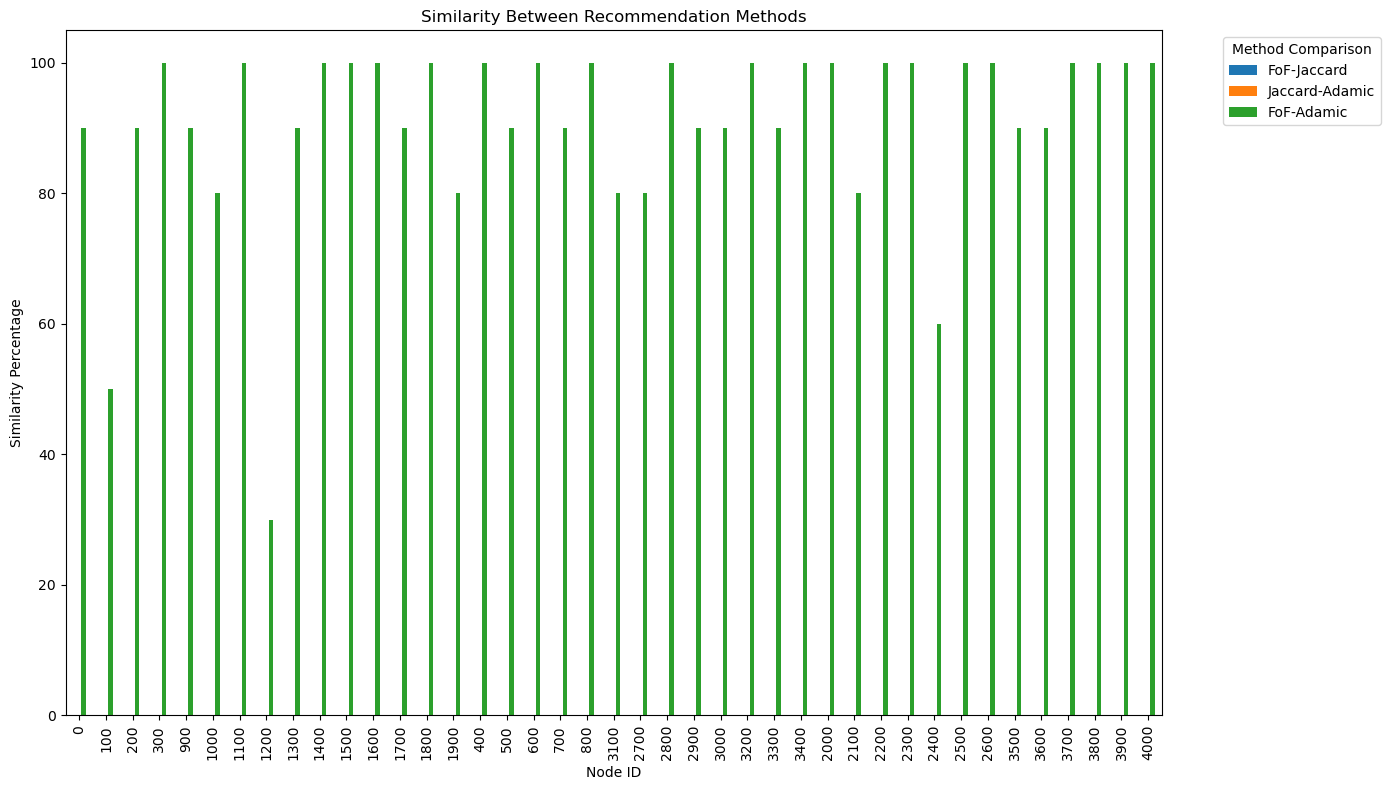

Average Similarities: {'FoF-Jaccard': 0.0, 'Jaccard-Adamic': 0.0, 'FoF-Adamic': 90.73170731707317}


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot similarities function
def plot_similarities(similarities):
    df = pd.DataFrame(similarities).T
    df.plot(kind='bar', figsize=(14, 8))
    plt.title('Similarity Between Recommendation Methods')
    plt.xlabel('Node ID')
    plt.ylabel('Similarity Percentage')
    plt.legend(title='Method Comparison', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Generate similarity data
similarities = evaluate_similarity(G, multiples_of_100)

# Plot similarities
plot_similarities(similarities)

# Print average similarities for context in the presentation
average_similarities = {key: sum(d[key] for d in similarities.values()) / len(similarities) for key in ['FoF-Jaccard', 'Jaccard-Adamic', 'FoF-Adamic']}
print("Average Similarities:", average_similarities)


### Plots of Average Ranks of Correct Recommendations


The graph shows the average ranks of correct recommendations after a known friendship is removed and then re-added to the network. The FoF method has an average rank of 1.73, while the Adamic-Adar method has a slightly better average rank of 1.58. This indicates that Adamic-Adar is marginally more effective in correctly identifying the removed friend compared to FoF. The lower the average rank, the higher the accuracy of the method in predicting true friendships, suggesting that Adamic-Adar may provide more accurate recommendations in this context.


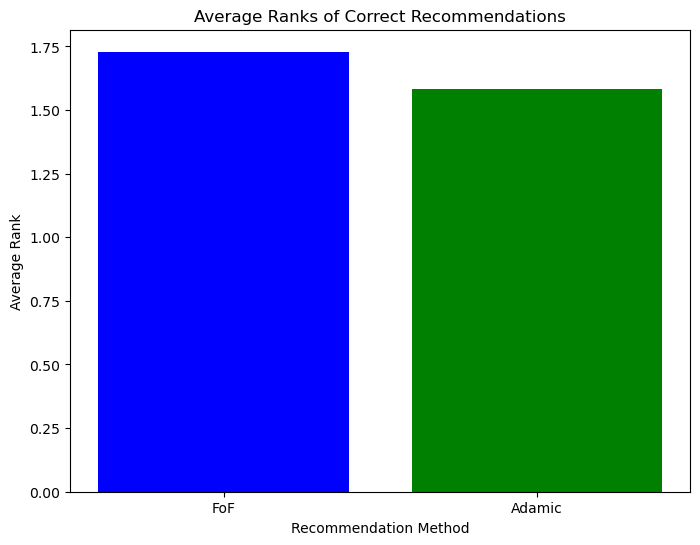

Average ranks of correct recommendations: {'FoF': 1.7291666666666667, 'Adamic': 1.5833333333333333}


In [25]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import random
import networkx as nx

# Assuming you have the necessary recommendation functions defined:
# recommend_common_neighbors(G, node, top_n=10)
# recommend_adamic_adar(G, node, top_n=10)

# Optimized function to calculate average ranks and plot them
def rank_of_friendship_removal_and_plot_optimized(G, trials=50, n_jobs=-1):
    ranks = {'FoF': [], 'Adamic': []}
    random_pairs = random.sample(list(G.edges()), trials)

    def process_pair(f1, f2):
        G.remove_edge(f1, f2)
        f1_recommendations = {
            'FoF': recommend_common_neighbors(G, f1),
            'Adamic': recommend_adamic_adar(G, f1)
        }
        f2_recommendations = {
            'FoF': recommend_common_neighbors(G, f2),
            'Adamic': recommend_adamic_adar(G, f2)
        }

        ranks_local = {'FoF': None, 'Adamic': None}

        for method in ranks.keys():
            f1_rank = next((index for index, (node, _) in enumerate(f2_recommendations[method]) if node == f1), None)
            f2_rank = next((index for index, (node, _) in enumerate(f1_recommendations[method]) if node == f2), None)
            if f1_rank is not None and f2_rank is not None:
                ranks_local[method] = (f1_rank + f2_rank) / 2.0

        G.add_edge(f1, f2)
        return ranks_local

    results = Parallel(n_jobs=n_jobs)(delayed(process_pair)(f1, f2) for f1, f2 in random_pairs)

    for result in results:
        for method in ranks.keys():
            if result[method] is not None:
                ranks[method].append(result[method])

    average_ranks = {method: sum(ranks[method]) / len(ranks[method]) if ranks[method] else None for method in ranks}

    # Filter out None values and ensure all methods are included
    average_ranks = {k: (v if v is not None else float('nan')) for k, v in average_ranks.items()}

    plt.figure(figsize=(8, 6))
    plt.bar(average_ranks.keys(), average_ranks.values(), color=['blue', 'green'])
    plt.title('Average Ranks of Correct Recommendations')
    plt.xlabel('Recommendation Method')
    plt.ylabel('Average Rank')
    plt.show()

    return average_ranks

# Load your graph (assuming G is already defined and loaded)
# Run the optimized function and plot average ranks
average_ranks = rank_of_friendship_removal_and_plot_optimized(G, trials=50, n_jobs=-1)
print("Average ranks of correct recommendations:", average_ranks)


- We can understand that these findings suggest that while FoF and Adamic-Adar methods are similar in their recommendations, Adamic-Adar might be more precise in predicting actual friendships. The Jaccard method's lack of overlap with the other methods points to its unique approach, which could be beneficial in identifying less obvious connections in a social network.